Find pulse reliability maps for each subject:

In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
from scipy.signal import find_peaks
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import clean_img
from nilearn.image import new_img_like
from sklearn.metrics import r2_score
from nilearn.image import mean_img
import os


In [ ]:
# get subjects from subjects.txt:
# Path to your subject list file
subjects_file = r"D:\HCP_vessel_files\subjects.txt"

# Read all IDs into a Python list
with open(subjects_file, "r") as f:
    subjects = [line.strip() for line in f if line.strip()]

print("Loaded", len(subjects), "subjects:")

# subjects = subjects[:4]
print(subjects)  # show the first 10 to check


Loaded 190 subjects:
['100307', '101309', '102008', '102311', '103111', '103414', '103818', '105014', '107422', '108828', '109123', '110411', '111716', '113619', '113821', '113922', '114419', '115320', '116524', '118528', '118932', '120212', '121618', '123420', '124220', '124826', '127630', '128127', '129533', '130013', '132118', '133827', '136833', '137027', '137128', '137936', '138231', '140117', '140824', '142424', '142828', '143325', '144832', '145531', '146331', '146432', '148941', '150423', '150726', '151627', '153833', '154734', '154936', '155635', '156637', '158035', '159138', '161630', '161731', '162733', '163331', '164131', '165032', '167743', '168341', '169343', '169444', '170934', '172130', '172938', '173536', '175035', '177645', '178950', '179346', '180129', '180836', '180937', '181232', '183034', '185139', '186141', '187143', '187547', '188347', '189349', '191033', '191437', '191841', '192540', '192843', '194140', '194847', '195849', '197348', '198855', '199150', '199251'

In [3]:
import numpy as np
import nibabel as nib

def corr_r2(a, b):
    """Pearson r^2 ignoring NaNs; returns NaN if too few points."""
    mask = np.isfinite(a) & np.isfinite(b)
    if mask.sum() < 5:  # require at least ~10 bins in common
        return np.nan
    r = np.corrcoef(a[mask], b[mask])[0, 1]
    return float(r*r)

def bin_means_along_phase(x_sorted_1d, bin_idx, nbins):
    """Mean per phase bin for one voxel, one group."""
    out = np.full(nbins, np.nan, dtype=float)
    for k in range(nbins):
        sel = (bin_idx == k)
        if np.any(sel):
            out[k] = np.mean(x_sorted_1d[sel])
    return out

def reliability_volume_random_halves(theta_slices, fmri_slices,
                                     nbins=180, B=100, seed=0):
    """
    theta_slices[s]: (N,) phase values for slice s  (radians, typically in (-pi,pi])
    fmri_slices[s]:  (nx, ny, N) fMRI data for slice s
    Returns: (nx, ny, nslices) median r^2 reliability.
    """
    rng = np.random.default_rng(seed)
    nslices = len(theta_slices)
    nx, ny, N = fmri_slices[0].shape
    rel = np.full((nx, ny, nslices), np.nan, dtype=np.float32)

    # fixed phase bins across all slices
    # edges = np.linspace(-np.pi, np.pi, nbins + 1)
    edges = np.linspace(0, 1, nbins + 1)

    # print(f"edges.shape {edges.shape}")

    for s in range(nslices):
        nx, ny, N = fmri_slices[s].shape

        phi = theta_slices[s]                  # (N,)
        X = fmri_slices[s]                     # (nx, ny, N)
        # print(f"X.shape {X.shape}")
        idx = np.argsort(phi)
        phi_sorted = phi[idx]
        X_sorted = X[:, :, idx]                # reorder timepoints by ascending phase

        # bin index for each (sorted) timepoint
        bin_idx = np.digitize(phi_sorted, edges) - 1
        bin_idx[bin_idx == nbins] = nbins - 1  # clamp edge case
        # print(f"bin_idx {bin_idx}")

        # precompute time indices per bin to speed up per-voxel means
        inds_per_bin = [np.where(bin_idx == k)[0] for k in range(nbins)]

        # prepare accumulator for r^2 across B splits
        r2_stack = np.full((nx, ny, B), np.nan, dtype=np.float32)

        time_idx_all = np.arange(N)

        for b in range(B):
            # random 50/50 split of timepoints
            take = rng.choice(N, N // 2, replace=False)
            maskA = np.zeros(N, dtype=bool); maskA[take] = True
            maskB = ~maskA

            # For each voxel, compute bin means for group A and B
            for i in range(nx):
                Xi = X_sorted[i]  # shape (ny, N); faster to reuse
                # print(f"Xi.shape {Xi.shape}")

                for j in range(ny):
                    x_ij = Xi[j]  # (N,)
                    # print(f"x_ij.shape {x_ij.shape}")

                    # bin means — group A
                    A = np.full(nbins, np.nan, dtype=float)
                    for k, inds in enumerate(inds_per_bin):
                        if inds.size:
                            sel = inds[maskA[inds]]
                            if sel.size:
                                A[k] = np.mean(x_ij[sel])

                    # bin means — group B
                    Bcurve = np.full(nbins, np.nan, dtype=float)
                    for k, inds in enumerate(inds_per_bin):
                        if inds.size:
                            sel = inds[maskB[inds]]
                            if sel.size:
                                Bcurve[k] = np.mean(x_ij[sel])

                    # # plot A and Bcurve to see it working. 
                    # if (i, j) == (20, 20) and b == 0:   # pick a voxel and first bootstrap
                    #     import matplotlib.pyplot as plt
                    #     plt.figure()
                    #     plt.plot(A, label="Half A")
                    #     plt.plot(Bcurve, label="Half B")
                    #     plt.title(f"Voxel ({i},{j}), slice {s}")
                    #     plt.xlabel("Phase bin")
                    #     plt.ylabel("Mean signal")
                    #     plt.legend()
                    #     plt.show()

                    r2_stack[i, j, b] = corr_r2(A, Bcurve)
                    # print(f"r2_stack: {r2_stack}")
        # aggregate across splits (median is robust)
        rel[:, :, s] = np.nanmedian(r2_stack, axis=2)
    return rel

# --- run it
# theta_slices: list of length nslices, each (N,)
# fmri_slices:  list of length nslices, each (nx, ny, N)
# NEED TO BE ABLE TO LOOK AT THE A AND Bcurve FOR DIFFERENT BIN SIZES.
# NEED A BRAIN MASK? no, want to see what noise there is. 
nbins = 40
B = 5
TR = 0.720


# nib.save(rel_img, fr'C:\DocumentsPC\DATA\HCP_PROCESSED\{subject}\pulse_R2\r2Linear_nbins{nbins}_B{B}_HPC{high_pass}_RPs{12}.nii.gz')


# # Optionally write a JSON sidecar with full provenance:
# import json, time
# meta = {
#     "method": "APP (phase-ordered) reliability via random half-splits",
#     "metric": "Pearson r^2 between binned curves; median over B splits",
#     "nbins": 180,
#     "B": 100,
#     "phase_ordering": "ascending (-pi..pi]",
#     "smoothing_after_APP": "not used for reliability; (only binning).",
#     "subject": "sub-XX",
#     "hpf_cutoff_hz": "<your_cutoff>",
#     "motion_regressors": "<describe>",
#     "date": time.strftime("%Y-%m-%d")
# }
# with open('sub-XX_task-YY_appReliability_r2.json', 'w') as f:
#     json.dump(meta, f, indent=2)

# 7m 30s

In [4]:
high_pass = 0.0042

for subjectid in subjects:
    file_path = fr'D:\hcp_processed\{subjectid}\PulseR2Linear_nbins{nbins}_B{B}_HPC{high_pass}_RPs{12}.nii.gz'
    if os.path.exists(file_path):
        print(f"Skipping {subjectid}, file already exists.")
        continue  # Skip this subject
    else:
        print(f"Processing {subjectid}...")

    # print(f"subject {subjectid}")
    fmri_nifti_file = fr"D:\hcp_processed\{subjectid}\motion_corrected\{subjectid}_REST1_LR_mc.nii.gz"
    fmri_img = nib.load(fmri_nifti_file)

    # apply motion correction (load in the realigned data and apply motion regression)
    # fmri_mean_nifti = mean_img(fmri_img) # Compute mean fmri image before detrending
    # fmri_mean = np.mean(fmri_img.get_fdata(), axis=3)   # average over time

    # --- MOTION PARAMETERS REGRESSTION ---
    fmri_data = fmri_img.get_fdata()  # shape: (X, Y, Z, T)
    fmri_mean = np.nanmean(fmri_data, axis=3, keepdims=True) # get mean for normalization later

    motion_array = np.load(fr"D:\hcp_processed\{subjectid}\motion_corrected\motion_array.npy")
    motion_deriv = np.vstack([np.zeros((1, 6)), np.diff(motion_array, axis=0)])
    motion_24reg = np.hstack([
        motion_array,
        motion_deriv,
        # motion_array ** 2,
        # motion_deriv ** 2
    ]) # shape: (T, 24)
    X, Y, Z, T = fmri_data.shape
    fmri_2d = fmri_data.reshape(-1, T).T  # shape: (T, V)
    # Add intercept (constant term)
    design_matrix = np.hstack([np.ones((T, 1)), motion_24reg])  # shape: (T, 25)
    # Solve linear regression: Y = X*B + E => E = residuals
    beta_hat = np.linalg.lstsq(design_matrix, fmri_2d, rcond=None)[0]  # shape: (25, V)
    predicted = design_matrix @ beta_hat  # shape: (T, V)
    residuals = fmri_2d - predicted  # shape: (T, V)
    residuals_4d = residuals.T.reshape(X, Y, Z, T) # the data with motion regression. 
    cleaned_img = nib.Nifti1Image(residuals_4d, affine=fmri_img.affine, header=fmri_img.header)
    fmri_img = cleaned_img
    # -- end motion correction ---

    # # High pass filtering 
    fmri_img = clean_img(fmri_img, detrend=True, high_pass = high_pass, standardize=False, t_r=TR)
    fmri_data = fmri_img.get_fdata()

    # load in the pulse information:
    output_dir = fr"D:\hcp_processed\{subjectid}"
    subject = f'{subjectid}_REST1_LR'
    save_path = os.path.join(output_dir, f"{subject}_cardiac_alignment_data.npz") # "D:\hcp_processed\100307\100307_REST1_LR_cardiac_alignment_data.npz
    cardiac_alignment_info = np.load(save_path, allow_pickle=True)

    # Get 3D aligned data:  
    fmri_slices = []
    theta_slices = []
    
    valid_fmri_indices_arr = cardiac_alignment_info["valid_fmri_indices"]
    # If it's a 0-D object array (rare), extract the Python object:
    if valid_fmri_indices_arr.ndim == 0 and valid_fmri_indices_arr.dtype == object:
        valid_fmri_indices_arr = valid_fmri_indices_arr.item()
    cardiac_phase_arr = cardiac_alignment_info["cardiac_phase"]
    # If it's a 0-D object array (rare), extract the Python object:
    if cardiac_phase_arr.ndim == 0 and cardiac_phase_arr.dtype == object:
        cardiac_phase_arr = cardiac_phase_arr.item()

    for slice_idx  in np.arange(fmri_data.shape[2]):
        fmri_data_2D = fmri_data[:,:,slice_idx,:]
        fmri_data_2D = fmri_data_2D.reshape(fmri_data.shape[0]*fmri_data.shape[1], fmri_data.shape[3])
        
        valid_fmri_indices = valid_fmri_indices_arr[slice_idx]
        cardiac_phase = cardiac_phase_arr[slice_idx]

        fmri_data_2D_trunc = fmri_data_2D[:, valid_fmri_indices]
        theta = cardiac_phase[valid_fmri_indices]  # Keep only valid phases
        fmri_data_2D = fmri_data[:,:,slice_idx,:]
        fmri_data_2D = fmri_data_2D.reshape(fmri_data.shape[0]*fmri_data.shape[1], fmri_data.shape[3])
        fmri_slices.append(fmri_data_2D_trunc.reshape(90, 104, -1))
        theta_slices.append(theta)

    rel_vol = reliability_volume_random_halves(theta_slices, fmri_slices,
                                            nbins=nbins, B=B, seed=0) # nbins=180, B=100
    

    # --- save as NIfTI (re-using geometry from your original 4D fMRI if you have it)
    # Suppose you have a reference nibabel image "fmri_img" with affine/header:
    #   fmri_img.shape == (nx, ny, nslices, N)
    affine = fmri_img.affine
    hdr = fmri_img.header.copy()
    hdr['descrip'] = b'APP reliability (random 50/50 r^2), linear phase; HPF=<your_cutoff>; motion=<params>'
    rel_img = nib.Nifti1Image(rel_vol, affine, header=hdr)
    print(f"rel_img.shape {rel_img.shape}")

    # nib.save(rel_img, fr'D:\hcp_processed\{subjectid}\PulseR2Linear_nbins{nbins}_B{B}_HPC{high_pass}_RPs{12}.nii.gz')
    nib.save(rel_img, file_path)



Processing 100307...


C:\Users\march\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\march\AppData\Local\Temp\ipykernel_35972\395554212.py:108: RuntimeWarning: All-NaN slice encountered
  rel[:, :, s] = np.nanmedian(r2_stack, axis=2)


rel_img.shape (90, 104, 72)
Processing 101309...
rel_img.shape (90, 104, 72)
Processing 102008...
rel_img.shape (90, 104, 72)
Processing 102311...
rel_img.shape (90, 104, 72)
Processing 103111...
rel_img.shape (90, 104, 72)
Processing 103414...
rel_img.shape (90, 104, 72)
Processing 103818...
rel_img.shape (90, 104, 72)
Processing 105014...
rel_img.shape (90, 104, 72)
Processing 107422...
rel_img.shape (90, 104, 72)
Processing 108828...
rel_img.shape (90, 104, 72)
Processing 109123...
rel_img.shape (90, 104, 72)
Processing 110411...
rel_img.shape (90, 104, 72)
Processing 111716...
rel_img.shape (90, 104, 72)
Processing 113619...
rel_img.shape (90, 104, 72)
Processing 113821...
rel_img.shape (90, 104, 72)
Processing 113922...
rel_img.shape (90, 104, 72)
Processing 114419...
rel_img.shape (90, 104, 72)
Processing 115320...
rel_img.shape (90, 104, 72)
Processing 116524...
rel_img.shape (90, 104, 72)
Processing 118528...
rel_img.shape (90, 104, 72)
Processing 118932...
rel_img.shape (90, 1

In [5]:
import ants
import nibabel as nib

def fMRI_to_MNI(fMRI_img_path, subjectid, interpolator="linear",
                mni_template_path=r"D:\Templates\mni_template.nii"): # "D:\Templates\mni_template.nii"
    """
    Register a volume from subject's native fMRI space to MNI space.

    Parameters
    ----------
    fMRI_img_path : str
        Path to the fMRI-space NIfTI you want to map into MNI (e.g., mean EPI or a map).
    subjectid : str
        Subject ID used to locate transforms.
    interpolator : str
        'linear' or 'BSpline' for continuous maps; 'nearestNeighbor' for labels/masks.
    mni_template_path : str
        MNI template that matches the T1w→MNI transforms you computed (resolution matters!).

    Returns
    -------
    nib.Nifti1Image
        The input volume resampled in MNI space.
    """
    transform_dir = fr"D:\hcp_processed\{subjectid}\transforms"
    # forward transforms (do NOT invert for fMRI→MNI)
    affine_fmri_to_t1 = fr"{transform_dir}\fMRI_to_T1w_0GenericAffine.mat"
    affine_t1_to_mni  = fr"{transform_dir}\T1w_to_MNI_0GenericAffine.mat"
    warp_t1_to_mni    = fr"{transform_dir}\T1w_to_MNI_1Warp.nii.gz"  # forward field

    fixed_mni = ants.image_read(mni_template_path)     # target (MNI) space
    moving_epi = ants.image_read(fMRI_img_path)        # source (native fMRI) space

    transformed = ants.apply_transforms(
        fixed=fixed_mni,
        moving=moving_epi,
        # Order here is important: last in list is applied first.
        transformlist=[warp_t1_to_mni, affine_t1_to_mni, affine_fmri_to_t1],
        whichtoinvert=[False, False, False],
        interpolator=interpolator
    )

    # Return as nibabel NIfTI using the MNI header/affine
    mni_ref = nib.load(mni_template_path)
    out_img = nib.Nifti1Image(transformed.numpy(), affine=mni_ref.affine, header=mni_ref.header)
    return out_img


In [6]:
# load in pulse reliability, Fisher average across, and display with MNI:
# check for outliers, bad data, remove those subjects 

In [7]:
def fisher_transform(r):
    """Applies Fisher z-transformation to correlation values (r)."""
    return 0.5 * np.log((1 + r) / (1 - r))

def inverse_fisher_transform(z):
    """Converts a Fisher z-score back to correlation values (r)."""
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)


In [8]:
# average subjects together:
subject_z_maps = []
for subjectid in subjects:
    file_path = fr'D:\hcp_processed\{subjectid}\PulseR2Linear_nbins{nbins}_B{B}_HPC{high_pass}_RPs{12}.nii.gz'
    print(f"subject {subjectid}")
    # rel_img = nib.load(file_path)
    pulse_r2_nifti = fMRI_to_MNI(file_path, subjectid, interpolator="linear")


    r2_data = pulse_r2_nifti.get_fdata()  # Load as numpy array

    r2_data[r2_data < 0] = np.nan  # Ignore negative R² values by setting them to NaN
    r_data = np.sqrt(r2_data) # Convert R² to r (assuming positive correlations)

    z_data = np.where(~np.isnan(r_data), fisher_transform(r_data), np.nan) # Convert r to Fisher z-space (ignoring NaNs)
    subject_z_maps.append(z_data)

# Stack across time and compute mean in Fisher z-space (ignoring NaNs)
z_maps_stack = np.stack(subject_z_maps, axis=-1)
mean_z_map = np.nanmean(z_maps_stack, axis=-1)

mean_r_map = inverse_fisher_transform(mean_z_map) # Convert back to r-space
mean_r2_map = mean_r_map ** 2 # Convert back to R²
mean_r2_nifti = nib.Nifti1Image(mean_r2_map, affine=pulse_r2_nifti.affine, header=pulse_r2_nifti.header)

# # convert to MNI space for the subject
# output_nifti_path = fr'{path_pulseR2}\MNI_pulseR2.nii.gz'
# pulseR2_mni_paths[subject] = fmri_to_MNI(mean_r2_nifti, subject, output_nifti_path) # path for r2 maps for each subject in mni space


subject 100307
subject 101309
subject 102008
subject 102311
subject 103111
subject 103414
subject 103818
subject 105014
subject 107422
subject 108828
subject 109123
subject 110411
subject 111716
subject 113619
subject 113821
subject 113922
subject 114419
subject 115320
subject 116524
subject 118528
subject 118932
subject 120212
subject 121618
subject 123420
subject 124220
subject 124826
subject 127630
subject 128127
subject 129533
subject 130013
subject 132118
subject 133827
subject 136833
subject 137027
subject 137128
subject 137936
subject 138231
subject 140117
subject 140824
subject 142424
subject 142828
subject 143325
subject 144832
subject 145531
subject 146331
subject 146432
subject 148941
subject 150423
subject 150726
subject 151627
subject 153833
subject 154734
subject 154936
subject 155635
subject 156637
subject 158035
subject 159138
subject 161630
subject 161731
subject 162733
subject 163331
subject 164131
subject 165032
subject 167743
subject 168341
subject 169343
subject 16

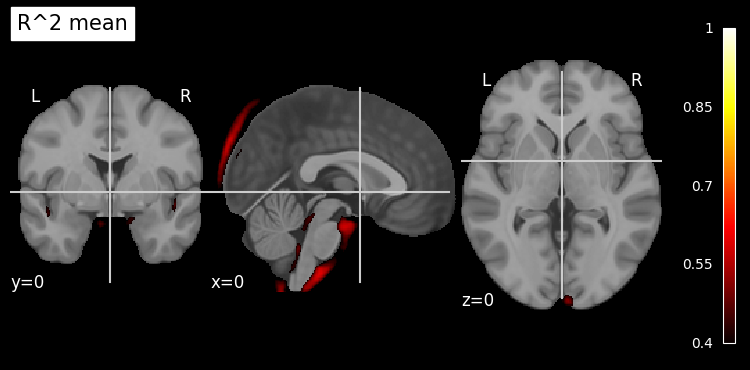

In [9]:
# plot group r2 image:
from nilearn import plotting
from nilearn.datasets import load_mni152_template
mni_template = load_mni152_template()

threshold = 0.4
vmax = 1
cut_coords = (0,0,0)
plotting.plot_stat_map(
    mean_r2_nifti,
    bg_img = mni_template,
    title=f"R^2 mean",
    cut_coords=cut_coords,
    colorbar=True,
    draw_cross=True,
    cmap = 'hot',
    vmin=threshold, vmax=vmax,
    alpha = 1, #0.5,
    threshold = threshold #0.0007
    )
plotting.show()

